# Train your custom YOLOv5 Visual Inspection model
*Based on and inspired by the  [Yolov5 Tutorials](https://github.com/ultralytics/yolov5/wiki/) by  [Ultralytics](https://ultralytics.com)*

In this notebook we are going to train a custom Yolov5 model for detecting anomalies in images. The data set for this demonstrator is based on wind turbine surface damage hosted on [kaggle.com](https://www.kaggle.com/datasets/ajifoster3/yolo-annotated-wind-turbines-586x371) 


A dataset of wind turbine surface damage composed of images from Shihavuddin & Chen's (2018) dataset, split into 586x371 pixel images with YOLO format annotations for Dirt and Damage. The dataset consists of 13000 images, just under 3000 of which have instances of one of the two classes.

**Source:** https://www.kaggle.com/datasets/ajifoster3/yolo-annotated-wind-turbines-586x371


**For academic works, please cite as:**
Foster, Ashley; Best, Oscar; Gianni, Mario; Khan, Asiya; Collins, Kerry; Sharma, Sanjay (2022),
"Drone Footage Wind Turbine Surface Damage Detection",
IEEE IVMSP 2022 (Accepted for publication)

**Original dataset:**

SHIHAVUDDIN, ASM; Chen, Xiao (2018),
“DTU - Drone inspection images of wind turbine”,
Mendeley Data,
V2,
doi: 10.17632/hd96prn3nc.2


**License:**
https://creativecommons.org/licenses/by-nc/4.0/
CC BY-NC 4.0 DEED
Attribution-NonCommercial 4.0 International



# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.60 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.
/opt/app-root/src/yolov5

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Install opencv-python-headless to avoid `ImportError: libGL.so.1: cannot open shared object file: No such file or directory`

In [2]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 140.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.9.16 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)


Setup complete ✅ (8 CPUs, 59.9 GB RAM, 45.6/99.5 GB disk)


# Test the setup 

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.9.16 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

100%|███████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 173MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/2 /opt/app-root/src/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 90.8ms
image 2/2 /opt/app-root/src/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 93.6ms
Speed: 0.4ms pre-process, 92.2ms infere

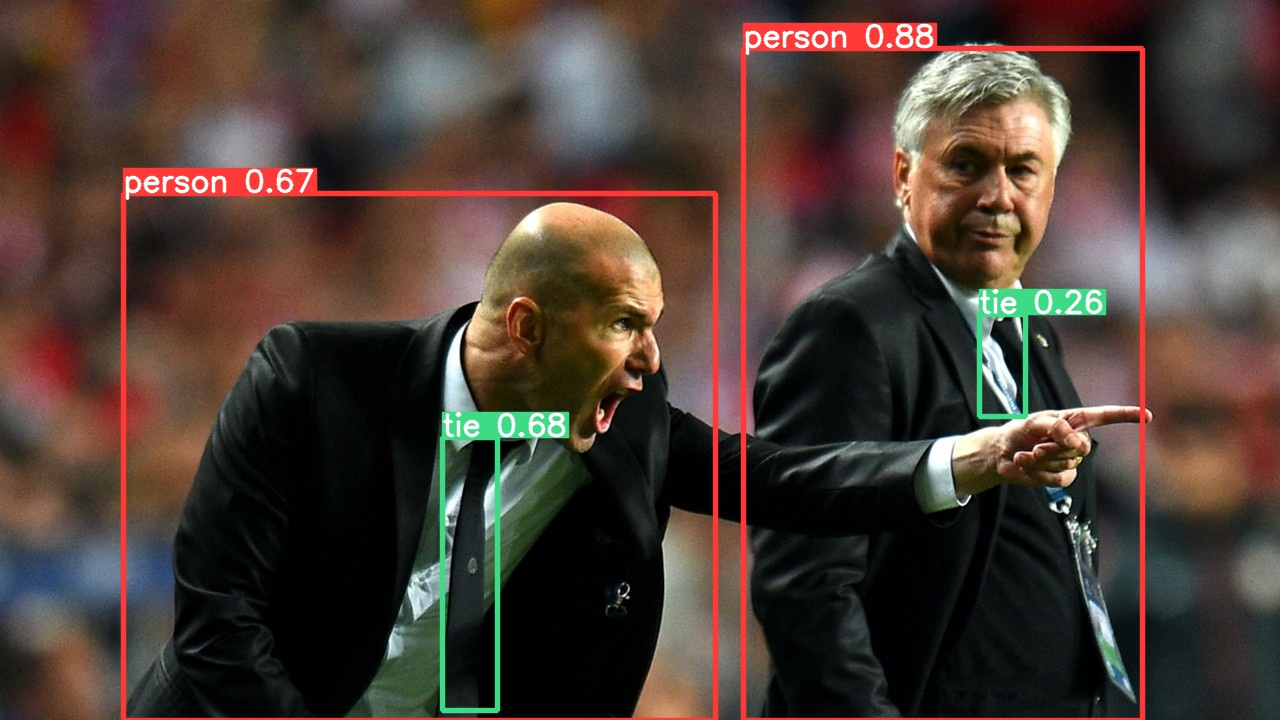

In [4]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

# What are YOLO v5 Annotations?
Before starting the model training, let's have a brief look at the required annotations.


## YOLO v5 Annotation Format
YOLO v5 expects annotations for each image in form of a .txt file where each line of the text file describes a bounding box. Consider the following image:

![zidane](images/zidane.jpg)

The annotation file for the image above looks like the following:

![zidane-txt](images/zidane-txt.png)

There are 3 objects in total (2 persons and one tie). Each line represents one of these objects. The specification for each line is as follows:

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
- Class numbers are zero-indexed (start from 0).

Source: [train-yolov5-custom-data](https://blog.paperspace.com/train-yolov5-custom-data/#convert-the-annotations-into-the-yolo-v5-format)

# Data preparation
Data preparation is usually a big task. You might have to clean the data. Label the data - in computer vision it means creating the bounding boxes. And also split the data into training and test data sets.

We are lucky, because this (hard) work has been done already. You just need to download and unpack the images and annotations. 

**Unzip the images and annotations:**

In [5]:
!pwd
!curl -LO https://github.com/sa-mw-dach/windy-journey/releases/download/v0.0.0/annotated-wind-turbine-surface-damage-200.tar.gz

/opt/app-root/src/yolov5
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 37.5M  100 37.5M    0     0  83.3M      0 --:--:-- --:--:-- --:--:-- 83.3M


In [6]:
!tar zxf annotated-wind-turbine-surface-damage-200.tar.gz -C data

In [7]:
!ls -l data/wind-turbine

total 20
-rw-r--r--. 1 1000780000 1000780000  106 Oct 31 07:35 data.yaml
-rw-r--r--. 1 1000780000 1000780000  929 Oct 31 07:40 README.txt
drwxr-sr-x. 4 1000780000 1000780000 4096 Oct 31 07:35 test
drwxr-sr-x. 4 1000780000 1000780000 4096 Oct 31 07:35 train
drwxr-sr-x. 4 1000780000 1000780000 4096 Oct 31 07:35 valid


In [8]:
!find data/wind-turbine -type d

data/wind-turbine
data/wind-turbine/train
data/wind-turbine/train/labels
data/wind-turbine/train/images
data/wind-turbine/test
data/wind-turbine/test/labels
data/wind-turbine/test/images
data/wind-turbine/valid
data/wind-turbine/valid/labels
data/wind-turbine/valid/images


**View a example image:** 

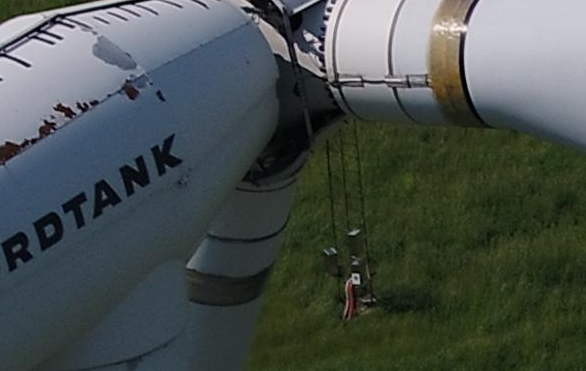

In [9]:
# View image 
display.Image(filename='data/wind-turbine/train/images/DJI_0021_03_04.png', width=600)

**Explore the Yolo annotation for the image:**

Let's have look at the annotation file for the image. It contains several damages:

In [10]:
# Show annotation
!cat data/wind-turbine/train/labels/DJI_0021_03_04.txt

1 0.195392 0.142857 0.080205 0.097035
1 0.232082 0.230458 0.047782 0.067385
1 0.162116 0.276280 0.017065 0.024259
1 0.139932 0.285714 0.020478 0.026954
1 0.109215 0.295148 0.044369 0.045822
1 0.081058 0.345013 0.032423 0.048518
1 0.034130 0.409704 0.068259 0.070081
1 0.313993 0.479784 0.023891 0.053908

# Start model training 
Train a YOLOv5m model on the metal-nut data by specifying dataset, batch-size, image size and pretrained --weights yolov5m.pt. Pretrained weights are auto-downloaded from the latest [YOLOv5 release](https://github.com/ultralytics/yolov5/releases).


In [11]:
!python train.py --img 640 --batch 16 --epochs 600 --data data/wind-turbine/data.yaml --weights yolov5m.pt 

train: weights=yolov5m.pt, cfg=, data=data/wind-turbine/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=600, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.9.16 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0

# Test the (pre-) trained model
Here we have two options:

**a)** The model training in the previous steps finsished and was suscessfull. Or you have reasonable results. E.g. low loss.

**b)** Due to resource or time constraints, it was not possible to complete the model training.

No worries, both paths are fine: 

**For a)**, set a MODEL env variable to the trained `weights/best.pt` file.

**For b)**,  download a pre-trained model and set a MODEL env variable to the pre-rained model file.


## Option a) - The model training in the previous steps finsished and was suscessfull
Depending on how many runs you already tried, please edit and update the cell below with the dir name `exp` to `exp[1-7]`. See `saved to runs/train/exp` above.

In [15]:
!find runs -name best.pt 

runs/train/exp/weights/best.pt


In [16]:
%env MODEL=runs/train/exp/weights/best.pt

env: MODEL=runs/train/exp/weights/best.pt


## Option b) - Due to resource or time constraints, it was not possible to complete the model training

In [46]:
# Download the pre-tained model

!curl -L https://github.com/sa-mw-dach/windy-journey/releases/download/v0.0.0/weights-best-2023_10_31-01_42.pt --output runs/model.pt

%env MODEL=runs/model.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  159M  100  159M    0     0  59.3M      0  0:00:02  0:00:02 --:--:-- 96.5M
env: MODEL=runs/model.pt


## Test the model
First, run `python detect.py` with a sample image:

In [17]:
!python detect.py --weights $MODEL --img 640 --conf 0.25 --source data/wind-turbine/train/images/DJI_0021_03_04.png


detect: weights=['runs/train/exp/weights/best.pt'], source=data/wind-turbine/train/images/DJI_0021_03_04.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.9.16 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /opt/app-root/src/yolov5/data/wind-turbine/train/images/DJI_0021_03_04.png: 416x640 9 damages, 93.3ms
Speed: 0.4ms pre-process, 93.3ms inference, 522.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


The last output line should contain `Results saved to runs/detect/exp2`. Please note the number of the exp and update the next cell before running the next cell.

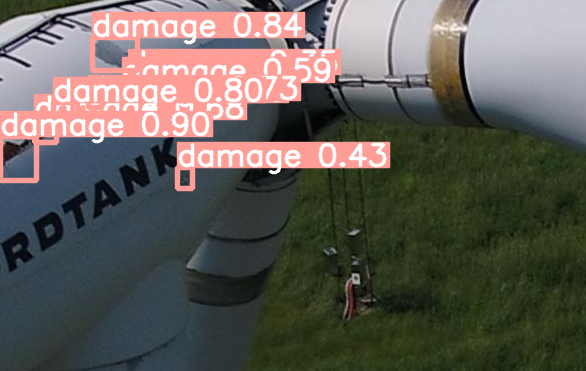

In [18]:
display.Image(filename='runs/detect/exp2/DJI_0021_03_04.png', width=600)

# Export YoloV5 model to ONNX format
Source: [01-yolov5_to_onnx.ipynb](https://github.com/rh-aiservices-bu/yolov5-model-serving/blob/main/01-yolov5_to_onnx.ipynb)
* Eventually modify the image size if you selected  a model with the "6" suffix, as image size is 1280 (and not 640)
* Stay at opset 16 for the moment for OpenVino model server compatibility

Please check again if you need to change `exp` to your latest run number. E.g. `exp[1-7]`.

In [19]:
!python export.py --weights runs/train/exp/weights/best.pt --include onnx --imgsz 640 --opset 16

export: data=data/coco128.yaml, weights=['runs/train/exp/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=16, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.9.16 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from runs/train/exp/weights/best.pt with output shape (1, 25200, 7) (40.2 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 kB 182.7 MB/s eta 0:00:00

requirements: Aut

# Upload onnx model to your S3 bucket for model serving

In [9]:
# First, check if we are still in the volov5 dir
!pwd
%cd yolov5

/opt/app-root/src/yolov5
[Errno 2] No such file or directory: 'yolov5'
/opt/app-root/src/yolov5


In [10]:
# Check if and where onnx file exixts
!ls -l runs/train/exp/weights/best.onnx

-rw-rw-r--. 1 1000780000 1000780000 83890314 Nov 15 11:14 runs/train/exp/weights/best.onnx


In [11]:
# Install boto3
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 36.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 170.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [13]:
from upload_model import upload_model
import boto3

upload_model("runs/train/exp/weights/best.onnx", "wvi-best.onnx")

src_file: "runs/train/exp/weights/best.onnx"
target_object_name: "wvi-best.onnx"
initializing S3 client
uploading model to bucket wvi as wvi-best.onnx
model uploaded and available as "wvi-best.onnx"
